# Crime_Project
* Observations and Trends at State Level
* Observations and Trends at Chicago

### Dependencies and Setup

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set()

pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Creating Function for the State Geographical location: Northern and Suthern States
def geo_state(df):
    northen_states_list = ['Alaska', 'Connecticut', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Maine', 'Massachusetts',
                       'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'New Hampshire', 'New Jersey',
                       'New York', 'North Dakota', 'Ohio', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota',
                       'Vermont', 'Wisconsin', 'Wyoming']
    df['Geo']='South'
    for row in df.itertuples():
        if row.State in northen_states_list:
            df.loc[row.Index, 'Geo'] = 'North'
    return df

### Import DataSets for Analysis
* states_total.csv (generated by api request: census_states.ipynb, source of data: census.org)

In [3]:
filter_columns = ['State_Name', 'Year', 'Population', 'House_Income', 'Per_Cap_Income', 'Pov_Rate','Unemp_Rate','Geo','Lat','Lng']
states_econ = pd.read_csv('resources/states_total.csv').filter(filter_columns)
states_econ = states_econ[(states_econ['Year'] == 2011)].filter(filter_columns)
states_econ.head()

,State_Name,Year,Population,House_Income,Per_Cap_Income,Pov_Rate,Unemp_Rate,Geo,Lat,Lng
0,Alabama,2011,"4,747,424.00","42,934.00","23,483.00",17.13,4.54,South,32.78,-86.83
1,Alaska,2011,"700,703.00","69,014.00","31,944.00",9.29,4.41,North,64.07,-152.28
2,Arizona,2011,"6,337,373.00","50,752.00","25,784.00",15.84,4.23,South,34.27,-111.66
3,Arkansas,2011,"2,895,928.00","40,149.00","21,833.00",17.85,3.94,South,34.89,-92.44
4,California,2011,"36,969,200.00","61,632.00","29,634.00",14.10,5.06,South,37.18,-119.47


* state_crime.csv 

In [4]:
filter_columns = ['State', 'Year', 'Data.Totals.Property.All', 'Data.Totals.Violent.All']
states_crime = pd.read_csv('resources/state_crime.csv')
states_crime = states_crime[(states_crime['Year'] == 2011)].filter(filter_columns)
states_crime = states_crime.rename(columns={
                    'State': 'State_Name',
                    'Data.Totals.Property.All': 'Crime_Prop',
                    'Data.Totals.Violent.All':'Crime_Viol'})
states_crime[['Crime_Prop', 'Crime_Viol']] = states_crime[['Crime_Prop', 'Crime_Viol']].astype(float)
states_crime.head()

,State_Name,Year,Crime_Prop,Crime_Viol
51,Alabama,2011,"173,192.00","20,166.00"
104,Alaska,2011,"19,094.00","4,416.00"
157,Arizona,2011,"229,896.00","26,789.00"
210,Arkansas,2011,"110,430.00","14,173.00"
263,California,2011,"973,822.00","154,943.00"


* NCSH.csv (Leading causes of Death) 

In [5]:
# Import and Cleaning CDC data
states_deaths = pd.read_csv('resources/ncsh.csv')
states_deaths = geo_state(states_deaths)
states_deaths.drop(states_deaths[states_deaths['State']=='United States'].index, inplace=True)
# Creating DataSet based on number of deaths
states_deaths_tot = states_deaths.drop(['113 Cause Name', 'Age-adjusted Death Rate'], 1)
states_deaths_tot = states_deaths_tot.set_index(['Year', 'Geo', 'State', 'Cause Name'], drop=True).unstack('Cause Name')
states_deaths_tot.columns = states_deaths_tot.columns.get_level_values(1)
states_deaths_tot = states_deaths_tot.rename(columns={
                                            "Alzheimer's disease": 'Alzheimer', 'Heart disease': 'Heart',
                                            'Influenza and pneumonia': 'Pneumonia', 'Kidney disease': 'Kidney',
                                            'Unintentional injuries': 'Injuries'})
states_deaths_tot.head()

Cause Name              All causes  Alzheimer  CLRD  Cancer  Diabetes  Heart  \
Year Geo   State                                                               
1999 North Alaska             2708         24   146     633        67    563   
           Connecticut       29446        449  1435    7054       691   9127   
           Idaho              9579        243   568    2162       267   2532   
           Illinois         108436       1908  5155   25024      3004  33387   
           Indiana           55303       1106  3053   12898      1591  16661   

Cause Name              Pneumonia  Kidney  Stroke  Suicide  Injuries  
Year Geo   State                                                      
1999 North Alaska              46      34     171       96       294  
           Connecticut        885     457    1933      274      1034  
           Idaho              289      99     771      181       597  
           Illinois          3121    1965    7714     1020      4125  
           Indiana           1362    1022    4057      628      2309

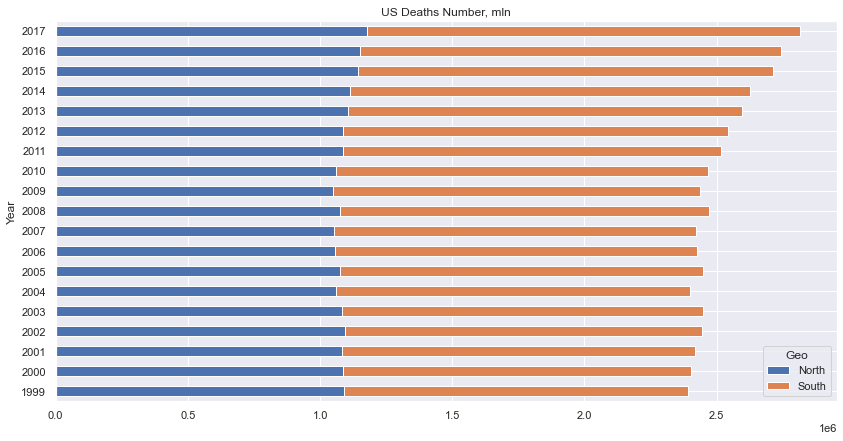

In [6]:
states_deaths_plot = states_deaths_tot.filter(['All causes'])
states_deaths_plot = states_deaths_plot.groupby([states_deaths_plot.index.get_level_values(0),
                          states_deaths_tot.index.get_level_values(1)])['All causes'].sum()
_=states_deaths_plot.unstack().plot(kind='barh', stacked=True, title="US Deaths Number, mln", figsize=(14, 7))

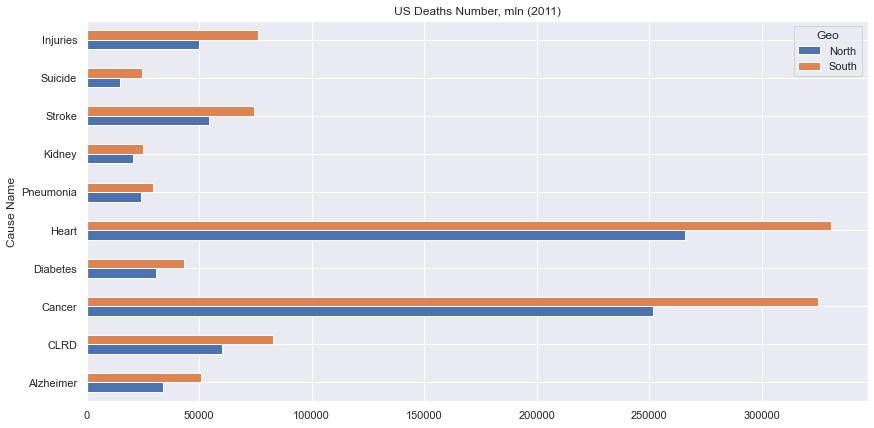

In [7]:
states_deaths_tot.reset_index(inplace=True)
deaths_2011 = states_deaths_tot.drop(['All causes'],1)
deaths_2011 = deaths_2011[deaths_2011['Year']==2011]
deaths_2011 = deaths_2011.drop(['Year'],1)
deaths_plot = deaths_2011.groupby('Geo').sum()
_=deaths_plot.transpose().plot(kind='barh', title="US Deaths Number, mln (2011)", figsize=(14, 7))

In [8]:
states_deaths_2011 = states_deaths_tot[states_deaths_tot['Year']==2011]
states_deaths_2011 = states_deaths_2011.sort_values('State').reset_index(drop=True)
states_deaths_2011 = states_deaths_2011.drop(['Year'],1)
states_deaths_2011['Population'] = states_econ['Population']
states_deaths_2011['All causes'] = states_deaths_2011['All causes']/states_deaths_2011['Population']*100000 
states_deaths_2011['Cancer'] = states_deaths_2011['Cancer']/states_deaths_2011['Population']*100000
states_deaths_2011['Heart'] = states_deaths_2011['Heart']/states_deaths_2011['Population']*100000 
states_deaths_2011['Pneumonia'] = states_deaths_2011['Pneumonia']/states_deaths_2011['Population']*100000 
states_deaths_2011['Suicide'] = states_deaths_2011['Suicide']/states_deaths_2011['Population']*100000 
states_deaths_2011['Injuries'] = states_deaths_2011['Injuries']/states_deaths_2011['Population']*100000 
states_deaths_2011_adj = states_deaths_2011.filter(['State', 'All causes', 'Cancer', 'Heart',
                                                    'Pneumonia', 'Suicide', 'Injuries'])
states_deaths_2011_adj.head()

Cause Name,State,All causes,Cancer,Heart,Pneumonia,Suicide,Injuries
0,Alabama,"1,025.42",215.55,251.55,20.03,13.78,56.07
1,Alaska,549.31,133.44,105.47,8.28,20.41,54.94
2,Arizona,763.42,168.68,168.24,10.89,18.30,48.85
3,Arkansas,"1,023.96",224.35,247.52,25.10,15.95,52.14
4,California,649.03,152.69,161.68,16.77,10.81,29.28


* merging datasets

In [9]:
states_data = pd.merge(states_econ, states_crime, how='inner')
states_data['Crime_Tot'] = states_data['Crime_Prop'] + states_data['Crime_Viol']
states_data['Crime_Adj'] = states_data['Crime_Tot']/states_data['Population']*100000
states_data['Crime_Prop_Adj'] = states_data['Crime_Prop']/states_data['Population']*100000
states_data['Crime_Viol_Adj'] = states_data['Crime_Viol']/states_data['Population']*100000
states_data_2011 = states_data[states_data['Year']==2011]
states_data_2011.to_csv("resources/states_2011.csv", encoding="utf-8", index=False)
states_data.head()

,State_Name,Year,Population,House_Income,Per_Cap_Income,Pov_Rate,Unemp_Rate,Geo,Lat,Lng,Crime_Prop,Crime_Viol,Crime_Tot,Crime_Adj,Crime_Prop_Adj,Crime_Viol_Adj
0,Alabama,2011,"4,747,424.00","42,934.00","23,483.00",17.13,4.54,South,32.78,-86.83,"173,192.00","20,166.00","193,358.00","4,072.90","3,648.13",424.78
1,Alaska,2011,"700,703.00","69,014.00","31,944.00",9.29,4.41,North,64.07,-152.28,"19,094.00","4,416.00","23,510.00","3,355.20","2,724.98",630.22
2,Arizona,2011,"6,337,373.00","50,752.00","25,784.00",15.84,4.23,South,34.27,-111.66,"229,896.00","26,789.00","256,685.00","4,050.34","3,627.62",422.71
3,Arkansas,2011,"2,895,928.00","40,149.00","21,833.00",17.85,3.94,South,34.89,-92.44,"110,430.00","14,173.00","124,603.00","4,302.70","3,813.29",489.41
4,California,2011,"36,969,200.00","61,632.00","29,634.00",14.10,5.06,South,37.18,-119.47,"973,822.00","154,943.00","1,128,765.00","3,053.26","2,634.14",419.11


## Data Exploration
* 2011

In [10]:
# Extracting Data for 2011
expl_data_2011 = states_data[states_data['Year']==2011].filter(['Geo', 'Lat', 'Pov_Rate', 'Unemp_Rate', 'Per_Cap_Income',
                                                                'House_Income', 'Crime_Prop_Adj', 'Crime_Viol_Adj', 'Crime_Adj'])

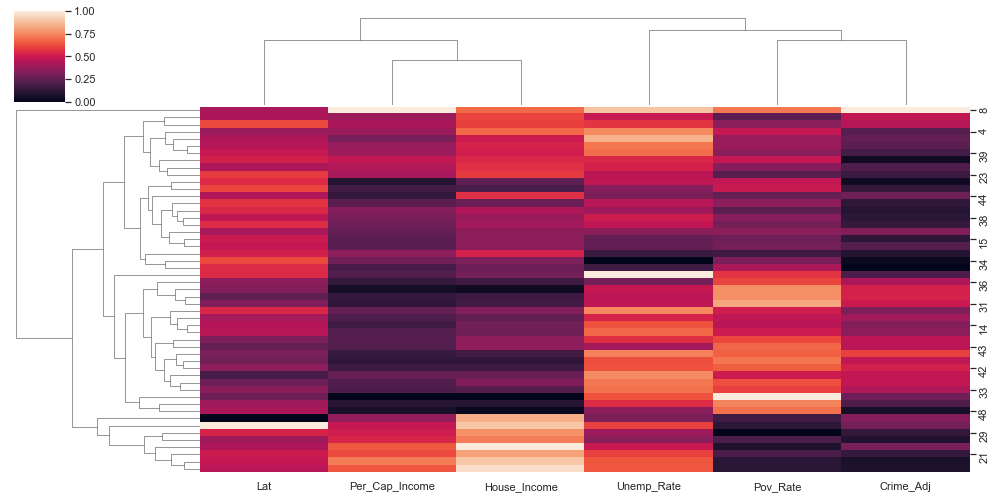

In [11]:
# Plot a hierarchically clustered heatmap
cluster_data = expl_data_2011.filter(['Pov_Rate', 'Lat', 'Unemp_Rate', 'Per_Cap_Income', 'House_Income', 'Crime_Adj'])
g = sns.clustermap(cluster_data, figsize=(14, 7), standard_scale=1)
plt.savefig('../images/dendrogram_2011.png')

In [12]:
# Correlation Matrix (Crime Adj Rate and Economic Indicators)
corr = expl_data_2011.corr()
print('Correlation Matrix, State Level, 2011')
corr.style.background_gradient(cmap='coolwarm')

Correlation Matrix, State Level, 2011


,Lat,Pov_Rate,Unemp_Rate,Per_Cap_Income,House_Income,Crime_Prop_Adj,Crime_Viol_Adj,Crime_Adj
Lat,1.000000,-0.451498,-0.107131,0.255678,0.261922,-0.498244,-0.161041,-0.452675
Pov_Rate,-0.451498,1.000000,0.295770,-0.583278,-0.797120,0.531410,0.352487,0.524317
Unemp_Rate,-0.107131,0.295770,1.000000,0.193028,0.057184,0.380437,0.478439,0.427287
Per_Cap_Income,0.255678,-0.583278,0.193028,1.000000,0.861788,-0.089936,0.312544,-0.003249
House_Income,0.261922,-0.797120,0.057184,0.861788,1.000000,-0.243375,0.049488,-0.191683
Crime_Prop_Adj,-0.498244,0.531410,0.380437,-0.089936,-0.243375,1.000000,0.655411,0.984839
Crime_Viol_Adj,-0.161041,0.352487,0.478439,0.312544,0.049488,0.655411,1.000000,0.776492
Crime_Adj,-0.452675,0.524317,0.427287,-0.003249,-0.191683,0.984839,0.776492,1.000000


In [15]:
# Correlation Matrix
states_deaths_2011_adj['Lat'] = states_data['Lat']
states_deaths_2011_adj['Crime_Adj'] = states_data['Crime_Adj']
states_deaths_2011_adj['Crime_Prop_Adj'] = states_data['Crime_Prop_Adj']
states_deaths_2011_adj['Crime_Viol_Adj'] = states_data['Crime_Viol_Adj']
corr = states_deaths_2011_adj.corr()
print('Correlation Matrix, State Level, 2011')
corr.style.background_gradient(cmap='coolwarm')

Correlation Matrix, State Level, 2011


Cause Name,All causes,Cancer,Heart,Pneumonia,Suicide,Injuries,Lat,Crime_Adj,Crime_Prop_Adj,Crime_Viol_Adj
Cause Name,,,,,,,,,,
All causes,1.000000,0.939342,0.886507,0.591834,0.021846,0.554600,-0.194911,-0.019115,0.000246,-0.084119
Cancer,0.939342,1.000000,0.835558,0.506632,-0.085363,0.381380,-0.081435,-0.075902,-0.065350,-0.093084
Heart,0.886507,0.835558,1.000000,0.676766,-0.228339,0.325274,-0.280166,0.029418,0.010999,0.088131
Pneumonia,0.591834,0.506632,0.676766,1.000000,-0.181850,0.203673,-0.291430,-0.154800,-0.171942,-0.049405
Suicide,0.021846,-0.085363,-0.228339,-0.181850,1.000000,0.659030,0.214722,-0.144351,-0.103518,-0.252460
Injuries,0.554600,0.381380,0.325274,0.203673,0.659030,1.000000,-0.000580,0.002160,0.030385,-0.100969
Lat,-0.194911,-0.081435,-0.280166,-0.291430,0.214722,-0.000580,1.000000,-0.452675,-0.498244,-0.161041
Crime_Adj,-0.019115,-0.075902,0.029418,-0.154800,-0.144351,0.002160,-0.452675,1.000000,0.984839,0.776492
Crime_Prop_Adj,0.000246,-0.065350,0.010999,-0.171942,-0.103518,0.030385,-0.498244,0.984839,1.000000,0.655411


                        Data exploration for 2011 year (Northern vs Southern States)


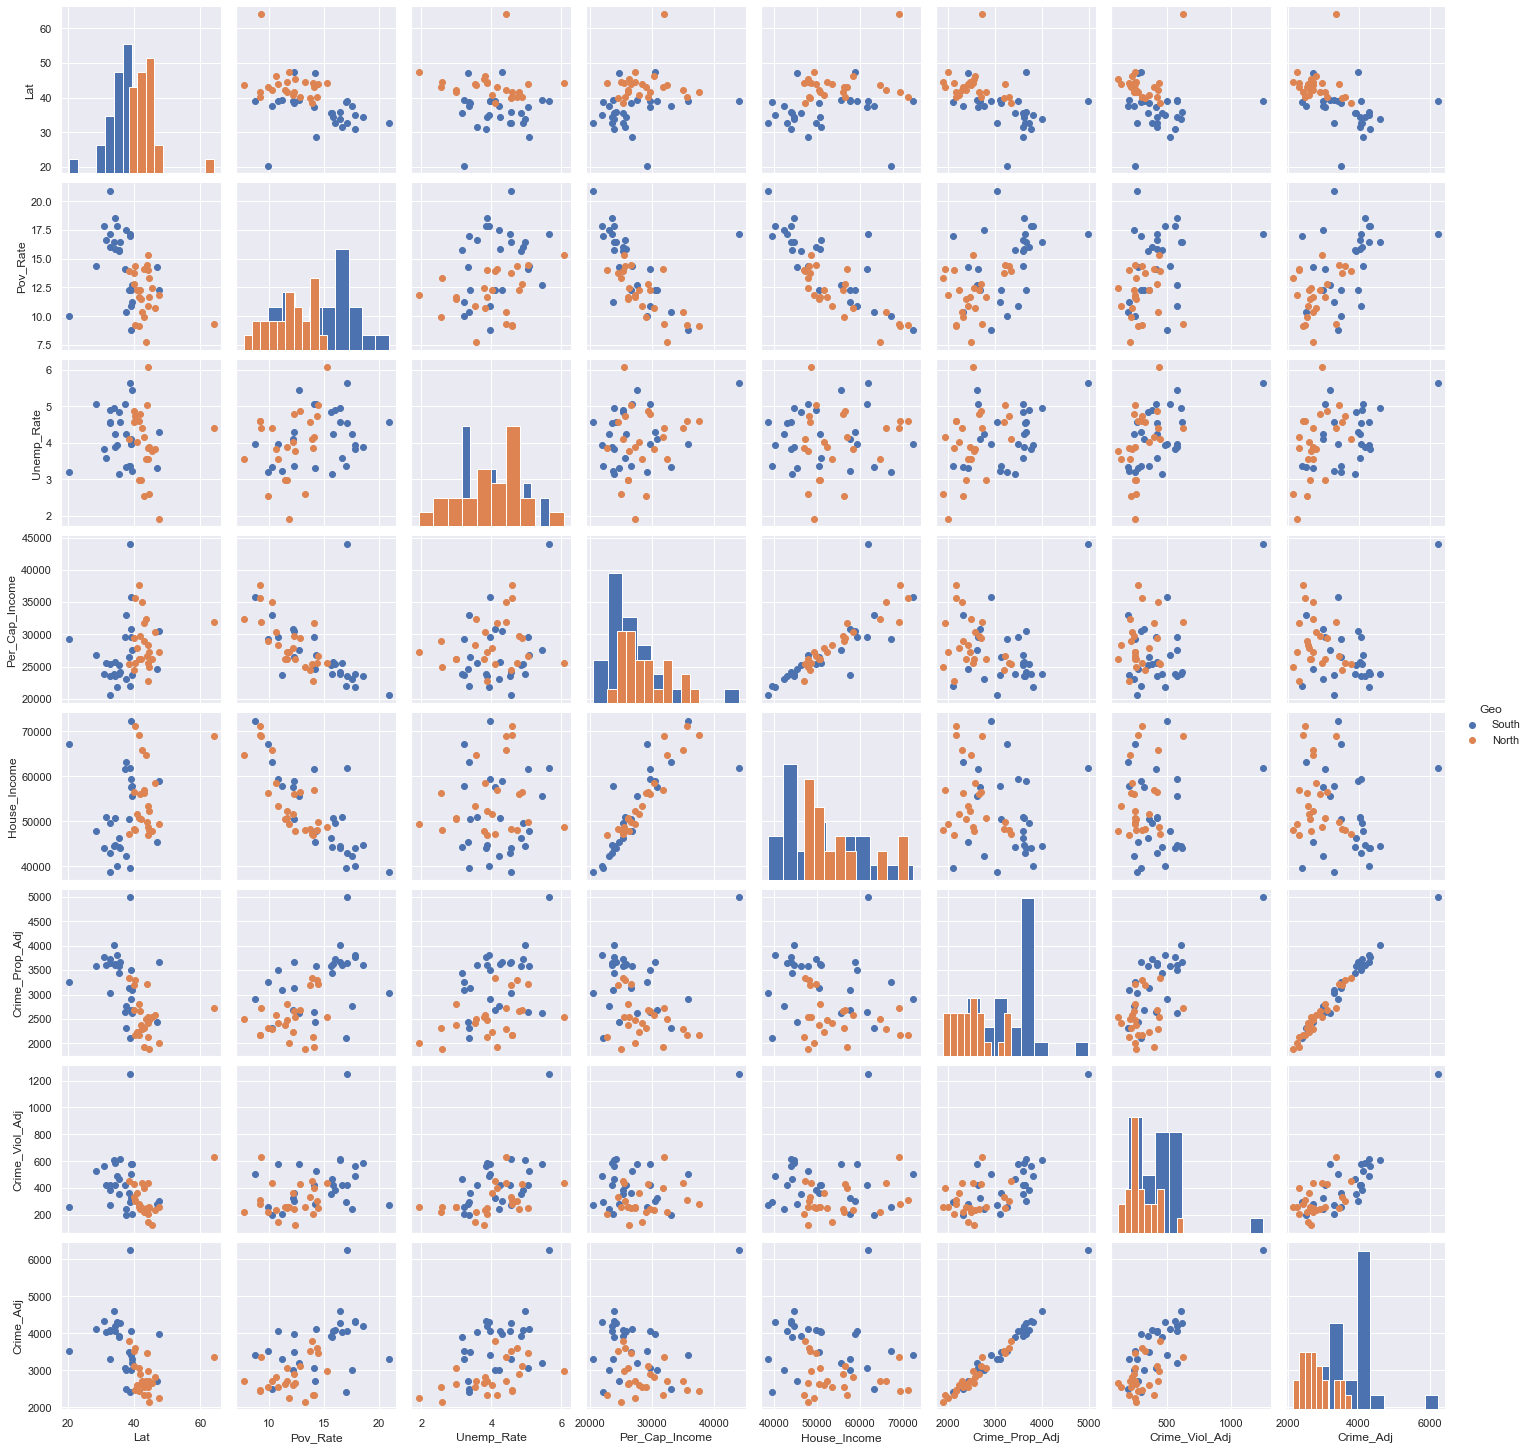

In [14]:
# Data Exploration for 2011
g=sns.PairGrid(expl_data_2011, hue='Geo')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
print(' '*23,'Data exploration for 2011 year (Northern vs Southern States)')
plt.savefig('images/exploration_2011.png')